In [1]:
import pandas as pd
import numpy as np
import re
from pprint import pprint

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel

#spacy for lemmatization
import spacy
import en_core_web_sm
spacy.load('en_core_web_sm')

#plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

#Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings('ignore',category= DeprecationWarning)

/usr/lib/python3/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [2]:
#iniializing stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [3]:
#importing the dataset
df = pd.read_excel('PublicDomainMissionaryTexts2.xlsx')
df.head()

,Author,Book
0,Andrew Melrose,ALEXANDER MACKAY\nMISSIONARY HERO OF UGANDA\nB...
1,Anthony N. Grooves,"JOURNAL\nOF A\nRESIDENCE AT BAGDAD, \nDURING T..."
2,Charles Stanley,Printed in Hong Kong by\nTHE EMPIRE PRINTING C...
3,Clara S. Fielder,SISTER ABIGAIL\n(ABIGAIL TOWNSEND LUFFE)\nBY\n...
4,E. H. Broadbent,THE PILGRIM CHURCH\n\n\nBEING SOME ACCOUNT OF ...


In [4]:
#cleaning
#convert to list
data = df.Book.values.tolist()

In [5]:
data = [re.sub('\s+', ' ', sent) for sent in data]
data = [re.sub("\'", " ", sent) for sent in data]
data = [re.sub('\[.*?\]', ' ', sent) for sent in data]
data = [re.sub('\w*\d\w*', ' ', sent) for sent in data]
data[:1]

['ALEXANDER MACKAY MISSIONARY HERO OF UGANDA BY THE AUTHOR OF ‘THE STORY OF STANLEY’ TENTH THOUSAND LONDON: THE SUNDAY SCHOOL UNION   and   Ludgate Hill, E. C. CONTENTS. CHAPTER PAGE I. A GOOD BEGINNING   II. CHOOSING HIS LIFE-WORK   III. ON AFRICAN SOIL   IV. DANGERS AND DIFFICULTIES   V. A VISIT TO LKONGE   VI. ARRIVAL AT UGANDA   VII. KING MTESA   VIII. DISAPPOINTMENT   IX. LABOUR AND RESULTS   X. STRANGE TASKS   XI. BUILDING THE ‘ELEANOR‘   XII. KING MWANGA   XIII. UGANDA. MARTYRS   XIV. GOOD-BYE TO UGANDA   XV. FRIENDS AND FELLOW-WORKERS   XVI. LAST DAYS   PREFACE TO SECOND EDITION. BY THE REV. T. C. WILSON (C. M. S. ). IT was in the early part of   that I made the acquaintance of A. M. Mackay, when, having offered for the mission to Uganda, I went up to London to meet those who were to be my fellow-missionaries in the ‘Dark Continent.’ He sailed before me to Zanzibar, but we met again there for a short time. Then I left the coast with our first caravan, and a long time was to ela

In [6]:
#Word Tokenization
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(data))
print(data_words[:1])

[['alexander', 'mackay', 'missionary', 'hero', 'of', 'uganda', 'by', 'the', 'author', 'of', 'the', 'story', 'of', 'stanley', 'tenth', 'thousand', 'london', 'the', 'sunday', 'school', 'union', 'and', 'ludgate', 'hill', 'contents', 'chapter', 'page', 'good', 'beginning', 'ii', 'choosing', 'his', 'life', 'work', 'iii', 'on', 'african', 'soil', 'iv', 'dangers', 'and', 'difficulties', 'visit', 'to', 'lkonge', 'vi', 'arrival', 'at', 'uganda', 'vii', 'king', 'mtesa', 'viii', 'disappointment', 'ix', 'labour', 'and', 'results', 'strange', 'tasks', 'xi', 'building', 'the', 'eleanor', 'xii', 'king', 'mwanga', 'xiii', 'uganda', 'martyrs', 'xiv', 'good', 'bye', 'to', 'uganda', 'xv', 'friends', 'and', 'fellow', 'workers', 'xvi', 'last', 'days', 'preface', 'to', 'second', 'edition', 'by', 'the', 'rev', 'wilson', 'it', 'was', 'in', 'the', 'early', 'part', 'of', 'that', 'made', 'the', 'acquaintance', 'of', 'mackay', 'when', 'having', 'offered', 'for', 'the', 'mission', 'to', 'uganda', 'went', 'up', 'to

In [7]:
#build bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

#Faster way to get sentences clubbed as bigrams or trigrams
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#see trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['alexander', 'mackay', 'missionary', 'hero', 'of', 'uganda', 'by', 'the', 'author', 'of', 'the', 'story', 'of', 'stanley', 'tenth', 'thousand', 'london', 'the', 'sunday_school', 'union', 'and', 'ludgate', 'hill', 'contents_chapter', 'page', 'good', 'beginning', 'ii', 'choosing', 'his', 'life', 'work', 'iii', 'on', 'african', 'soil', 'iv', 'dangers', 'and', 'difficulties', 'visit', 'to', 'lkonge', 'vi', 'arrival', 'at', 'uganda', 'vii', 'king', 'mtesa', 'viii', 'disappointment', 'ix', 'labour', 'and', 'results', 'strange', 'tasks', 'xi', 'building', 'the', 'eleanor', 'xii', 'king', 'mwanga', 'xiii', 'uganda', 'martyrs', 'xiv', 'good', 'bye', 'to', 'uganda', 'xv', 'friends', 'and', 'fellow', 'workers', 'xvi', 'last', 'days', 'preface', 'to', 'second', 'edition', 'by', 'the', 'rev', 'wilson', 'it', 'was', 'in', 'the', 'early', 'part', 'of', 'that', 'made', 'the', 'acquaintance', 'of', 'mackay', 'when', 'having', 'offered', 'for', 'the', 'mission', 'to', 'uganda', 'went', 'up', 'to', 'lon

In [8]:
#Define function for stopwords
def remove_stopwords(texts):
    return[[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
#Call out the functions

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['page', 'good', 'beginning', 'choose', 'life', 'work', 'african', 'soil', 'danger', 'difficulty', 'visit', 'lkonge', 'arrival', 'result', 'strange', 'task', 'friend', 'fellow', 'worker', 'xvi', 'last', 'day', 'early', 'part', 'make', 'acquaintance', 'offer', 'mission', 'go', 'missionary', 'dark', 'continent', 'sail', 'meet', 'short', 'time', 'leave', 'long', 'time', 'see', 'year', 'pass', 'murder', 'summer', 'nearly', 'year', 'alone', 'hear', 'store', 'southern', 'end', 'charge', 'native', 'mtesa', 'allow', 'go', 'man', 'voyage', 'month', 'native', 'canoe', 'evening', 'point', 'come', 'man', 'want', 'stop', 'night', 'far', 'get', 'dark', 'take', 'paddle', 'guide', 'canoe', 'dark', 'reach', 'place', 'fire', 'shot', 'recognise', 'signal', 'announce', 'arrival', 'turn', 'canoe', 'landward', 'soon', 'ground', 'ashore', 'ask', 'first', 'man', 'meet', 'come', 'coast', 'white', 'man', 'come', 'minute', 'grasp', 'mackay', 'hand', 'come', 'instead', 'send', 'go', 'letter', 'home', 'much', 'te

In [10]:
#Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

#create corpus
texts = data_lemmatized

#DTM
corpus = [id2word.doc2bow(text) for text in texts]

# print(corpus[:1])

In [11]:
#Building the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus= corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [46]:
#print the keywords in 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.000*"make" + 0.000*"go" + 0.000*"come" + 0.000*"time" + 0.000*"say" + '
  '0.000*"would" + 0.000*"give" + 0.000*"take" + 0.000*"year" + 0.000*"life"'),
 (1,
  '0.001*"make" + 0.001*"go" + 0.001*"say" + 0.001*"time" + 0.001*"man" + '
  '0.001*"would" + 0.001*"come" + 0.000*"know" + 0.000*"may" + 0.000*"find"'),
 (2,
  '0.001*"go" + 0.001*"say" + 0.001*"make" + 0.001*"would" + 0.001*"work" + '
  '0.000*"take" + 0.000*"day" + 0.000*"come" + 0.000*"time" + 0.000*"man"'),
 (3,
  '0.001*"say" + 0.000*"would" + 0.000*"come" + 0.000*"make" + 0.000*"day" + '
  '0.000*"go" + 0.000*"time" + 0.000*"man" + 0.000*"take" + 0.000*"work"'),
 (4,
  '0.021*"dog" + 0.019*"camp" + 0.012*"home" + 0.012*"day" + 0.011*"horse" + '
  '0.011*"make" + 0.010*"night" + 0.010*"fire" + 0.009*"sled" + 0.009*"meat"'),
 (5,
  '0.000*"come" + 0.000*"work" + 0.000*"would" + 0.000*"take" + 0.000*"man" + '
  '0.000*"time" + 0.000*"day" + 0.000*"say" + 0.000*"go" + 0.000*"make"'),
 (6,
  '0.035*"church" + 0.018*"hi

In [12]:
# Compute the Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.32180363262557665


In [14]:
#Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17     0.111713  0.023957       1        1  53.875370
7      0.199321  0.026097       2        1  12.675807
6      0.226306 -0.001079       3        1   8.371068
9      0.108618  0.175642       4        1   8.322367
14     0.177406 -0.031831       5        1   7.816898
4      0.036650 -0.212878       6        1   5.626611
15     0.107174 -0.062591       7        1   3.212859
8     -0.062763 -0.022092       8        1   0.086917
1     -0.053366  0.006035       9        1   0.001093
16    -0.070441  0.010751      10        1   0.001039
18    -0.069299  0.009352      11        1   0.001028
10    -0.077140  0.007018      12        1   0.000994
3     -0.076022  0.008189      13        1   0.000993
13    -0.076079  0.010392      14        1   0.000993
11    -0.076909  0.009309      15        1   0.000993
2     -0.080275  0.008495      16        1   0.000993
5     -0.080494  0.008770      17        1   0.000993
12    -0.080385  0.009249      18        1   0.000993
19    -0.082181  0.009050      19        1   0.000993
0     -0.081834  0.008166      20        1   0.000993, topic_info=    Category        Freq        Term       Total  loglift  logprob
739  Default  251.000000         say  251.000000  30.0000  30.0000
384  Default  244.000000          go  244.000000  29.0000  29.0000
163  Default  206.000000        come  206.000000  28.0000  28.0000
518  Default  206.000000        make  206.000000  27.0000  27.0000
149  Default   83.000000      church   83.000000  26.0000  26.0000
..       ...         ...         ...         ...      ...      ...
509  Topic20    0.000077        love   72.029510  -2.2261  -8.1417
111  Topic20    0.000075        call   60.680920  -2.0774  -8.1645
550  Topic20    0.000074  missionary   51.956421  -1.9449  -8.1872
328  Topic20    0.000075        feel   64.937836  -2.1571  -8.1764
881  Topic20    0.000075       thing   90.900757  -2.4810  -8.1640

[1416 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
979       1  0.803365    abatement
1920      3  0.990402        abbie
4775      5  0.824299  accommodate
10        1  0.362556      account
10        2  0.145022      account
...     ...       ...          ...
977       1  0.626402        young
977       2  0.214295        young
977       3  0.082421        young
977       4  0.049453        young
977       5  0.032969        young

[1201 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 8, 7, 10, 15, 5, 16, 9, 2, 17, 19, 11, 4, 14, 12, 3, 6, 13, 20, 1])

In [15]:
#Lets build the lda mallet model to improve on our lda model
mallet_path = 'mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [16]:
#show topics of updated mallet model
pprint(ldamallet.show_topics(formatted= False))


# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(17,
  [('young', 0.03330068560235064),
   ('friend', 0.02840352595494613),
   ('read', 0.023506366307541625),
   ('country', 0.023506366307541625),
   ('write', 0.02056807051909892),
   ('chapter', 0.019588638589618023),
   ('high', 0.01860920666013712),
   ('school', 0.01762977473065622),
   ('eye', 0.015670910871694418),
   ('knowledge', 0.015670910871694418)]),
 (9,
  [('impression', 0.036671368124118475),
   ('match', 0.02679830747531735),
   ('end', 0.022566995768688293),
   ('cricket', 0.022566995768688293),
   ('wicket', 0.021156558533145273),
   ('play', 0.019746121297602257),
   ('score', 0.018335684062059238),
   ('beat', 0.01692524682651622),
   ('throw', 0.01692524682651622),
   ('win', 0.014104372355430184)]),
 (13,
  [('service', 0.02774694783573807),
   ('poor', 0.0244173140954495),
   ('labour', 0.023307436182019976),
   ('village', 0.021087680355160933),
   ('hear', 0.021087680355160933),
   ('result', 0.01997780244173141),
   ('gospel', 0.018867924528301886),
   ('p

In [ ]:
#Coherence score got updated to 0.39 from 0.34

In [17]:
#Finding optimal number of topics from LDA

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [18]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

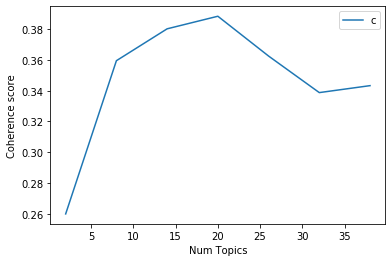

In [19]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Number of topics as 20 gives us the highest coherence score hence we will stick with it

In [20]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.046*"great" + 0.044*"send" + 0.044*"thing" + 0.041*"bring" + 0.035*"feel" '
  '+ 0.019*"morning" + 0.019*"return" + 0.017*"desire" + 0.016*"age" + '
  '0.016*"page"'),
 (1,
  '0.058*"life" + 0.041*"missionary" + 0.024*"carry" + 0.023*"story" + '
  '0.019*"meeting" + 0.018*"young" + 0.015*"order" + 0.015*"line" + '
  '0.014*"live" + 0.013*"service"'),
 (2,
  '0.037*"pray" + 0.032*"joy" + 0.031*"soul" + 0.026*"convert" + 0.025*"save" '
  '+ 0.022*"praise" + 0.020*"night" + 0.020*"happy" + 0.020*"conversion" + '
  '0.019*"seek"'),
 (3,
  '0.117*"church" + 0.023*"form" + 0.022*"increase" + 0.021*"reformation" + '
  '0.016*"scripture" + 0.013*"refer" + 0.013*"translate" + 0.012*"information" '
  '+ 0.012*"translation" + 0.012*"event"'),
 (4,
  '0.030*"power" + 0.030*"poor" + 0.023*"truth" + 0.019*"labour" + '
  '0.019*"service" + 0.017*"gospel" + 0.016*"result" + 0.012*"lead" + '
  '0.012*"hear" + 0.011*"village"'),
 (5,
  '0.043*"night" + 0.037*"time" + 0.028*"make" + 0.018*"smal

In [21]:
#Lets find the dominant topic in each sentence

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.2230,"arnot, reach, time, native, work, road, free, ...",ALEXANDER MACKAY MISSIONARY HERO OF UGANDA BY ...
1,1,18.0,0.3555,"place, present, river, receive, subject, steam...","JOURNAL OF A RESIDENCE AT BAGDAD, DURING THE Y..."
2,2,10.0,0.3501,"preach, word, find, chapter, lead, meet, soul,...",Printed in Hong Kong by THE EMPIRE PRINTING CO...
3,3,9.0,0.4038,"mother, child, dear, prayer, abbie, great, die...",SISTER ABIGAIL (ABIGAIL TOWNSEND LUFFE) BY CLA...
4,4,3.0,0.3949,"church, form, increase, reformation, scripture...",THE PILGRIM CHURCH BEING SOME ACCOUNT OF THE C...
5,5,7.0,0.2206,"arnot, reach, time, native, work, road, free, ...",THE LIFE & EXPLORATIONS OF FREDERICK STANLEY A...
6,6,2.0,0.3099,"pray, joy, soul, convert, save, praise, night,...","THE KING’S SON; OR, A MEMOIR OF BILLY BRAY. TH..."
7,7,19.0,0.2522,"soldier, remember, car, memory, face, german, ...",Dedicated to the memory of General George S. B...
8,8,6.0,0.3618,"friend, young, write, country, letter, read, l...",A SKETCH OF THE LIFE OF REV. JOSEPH HARDY NEES...
9,9,1.0,0.2694,"life, missionary, carry, story, meeting, young...",DAN CRAWFORD OF LUANZA Missionary Pioneers Who...


In [22]:
#Find most representative document for each topic

sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1.0,0.2694,"life, missionary, carry, story, meeting, young...",DAN CRAWFORD OF LUANZA Missionary Pioneers Who...
1,2.0,0.3099,"pray, joy, soul, convert, save, praise, night,...","THE KING’S SON; OR, A MEMOIR OF BILLY BRAY. TH..."
2,3.0,0.3949,"church, form, increase, reformation, scripture...",THE PILGRIM CHURCH BEING SOME ACCOUNT OF THE C...
3,4.0,0.3252,"power, poor, truth, labour, service, gospel, r...","RECOLLECTIONS OF AN EVANGELIST; or, INCIDENTS ..."
4,6.0,0.3618,"friend, young, write, country, letter, read, l...",A SKETCH OF THE LIFE OF REV. JOSEPH HARDY NEES...


In [23]:
#Lets find the subthemes in the documents

In [26]:
# lets see the percentage of topics the document is all about
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

new_text1 = 'Answered prayer'
tokens = [token for token in nltk.tokenize.word_tokenize(new_text.lower()) if token not in stop_words]
optimal_model[id2word.doc2bow(tokens)]

[(0, 0.04901960784313723),
 (1, 0.04901960784313723),
 (2, 0.04901960784313723),
 (3, 0.04901960784313723),
 (4, 0.04901960784313723),
 (5, 0.04901960784313723),
 (6, 0.04901960784313723),
 (7, 0.04901960784313723),
 (8, 0.04901960784313723),
 (9, 0.06644880174291937),
 (10, 0.05119825708061),
 (11, 0.04901960784313723),
 (12, 0.04901960784313723),
 (13, 0.04901960784313723),
 (14, 0.04901960784313723),
 (15, 0.04901960784313723),
 (16, 0.04901960784313723),
 (17, 0.04901960784313723),
 (18, 0.04901960784313723),
 (19, 0.04901960784313723)]

In [31]:
#This phrase appears less than one percent in all of the topics in the document
#Hence we can say that the words are discussed in the documents